# Import

In [3]:
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
os.environ['AWS_S3_ENDPOINT'] = 's3.af-south-1.amazonaws.com'
import xarray as xr
import rioxarray as rx
import pandas as pd
import numpy as np
import folium
from pystac_client import Client
from odc.stac import configure_rio
from matplotlib import pyplot as plt
from pathlib import Path

In [4]:
data_dir = Path('C:/data')
data_dir.exists()

True

# Connect to Digital Earth Africa 

In [5]:
catalog = Client.open("https://explorer.digitalearth.africa/stac")

configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Rainfall Daily

## Define spatial and temporal extent

In [6]:
bbox = [30.80, 2.48, 32.04, 3.87]
# start_date = "1981-01-01"
start_date = "2021-01-01"
end_date = "2022-12-31"
collections = ["rainfall_chirps_daily"]

## View spatial extent

In [5]:
# Calculate the center of the bounding box for map centering
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2

# Create a folium map centered at the bounding box's center
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Define the coordinates of the bounding box rectangle
# Folium uses (latitude, longitude) order for coordinates: bbox = [min long, min lat, max long, max lat]
polygon_coords = [
    (bbox[1], bbox[0]),   # Bottom-left: (minimum latitude (1), minimum longitude (0))
    (bbox[3], bbox[0]),  # Top-left: (maximum latitude (3), minimum longitude (0))
    (bbox[3], bbox[2]),  # Top-right: (maximum latitude (3), maximum longitude (2))
    (bbox[1], bbox[2]),  # Bottom-right: (minimum latitude (1), maximum longitude (2))
    (bbox[1], bbox[0]),  # Back to bottom-left to close the polygon
]

# Create a folium Polygon object with the bounding box coordinates
polygon = folium.Polygon(
    locations=polygon_coords,
    color='red',
    weight=2,
    fill=False
)

# Add the polygon to the map
polygon.add_to(m)

# Display the map in the Jupyter Notebook
m

## Query and Download

In [7]:
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}",
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 700 datasets


In [8]:
# set datetime to start_datetime
# for item in items:
#     item.properties['datetime'] = item.properties['start_datetime']

measurements = ["rainfall"]
crs = "EPSG:4326"
resolution = 0.05

datasets = []
for item in items:
    try:
        # data_array = rx.open_rasterio(item.assets['rainfall'].href, chunks={'x': 25, 'y': 29})
        data_array = rx.open_rasterio(item.assets['rainfall'].href, chunks={}) #accesses a dictionary named 'assets' within the current item. then access entry in the 'assets' dictionary that corresponds to the key 'rainfall'
        # timestamp = item.properties['datetime']
        timestamp = item.properties['start_datetime'] #access properties dictioinary, access value associated with start_datetime key
        data_array['time'] = timestamp # adds a coordinate named 'time' = timestamp to the data_array
        data_array = data_array.expand_dims(dim='time') #increases the dimensionality of the data_array by adding a new dimension named 'time'.
        data_array = data_array.squeeze('band') #remove "band" dimenion. 
        data_array.name = 'rainfall' # set the name of the DataArray
        datasets.append(data_array)
        print(f"Data appended for {item}")
    except Exception as e:
        print(f"Error loading item {item.id}: {type(e)}, {e}")

Data appended for <Item id=e0320ef9-c22c-5a99-b8b0-036d4597c1a2>
Data appended for <Item id=c37348a0-c56d-5776-b046-7dab11a45fa7>
Data appended for <Item id=fad112fc-0d00-5a8c-adaa-b6b79f64581c>
Data appended for <Item id=c12a4686-dd34-531c-b4b4-725d6f6f5935>
Data appended for <Item id=4ee95d87-1288-5efb-bfab-17f1f02a483f>
Data appended for <Item id=65ff9501-0954-511d-9851-5f4b37b9012b>
Data appended for <Item id=c1746e1a-52a4-5d5a-94cd-65f56a46fa50>
Data appended for <Item id=eba42ccc-8d77-5bb7-bb4a-11f6f90af29f>
Data appended for <Item id=550b6521-3ff3-5ea3-867f-377ad7b99861>
Data appended for <Item id=1987a7fa-0e8f-5643-af2f-08980bc3aa0a>
Data appended for <Item id=735de37b-d213-5626-9027-e651bf5bb931>


KeyboardInterrupt: 

In [49]:
if datasets:
    try:
        ds_manual_array = xr.concat(datasets, dim='time') # Concatenate into a DataArray
        ds_manual = ds_manual_array.to_dataset(name='rainfall') # Convert to a Dataset with 'rainfall' as the variable
        ds_manual = ds_manual.rio.write_crs(crs)
        ds_manual = ds_manual.rio.reproject(crs, resolution=resolution, transform=None)
        ds_manual = ds_manual.sel(x=slice(bbox[0], bbox[2]), y=slice(bbox[3], bbox[1])) # Apply bbox for consistency
    except Exception as e:
        print(f"Error concatenating datasets: {e}")
        ds_manual = None
else:
    ds_manual = None

# print(ds_manual) # Print the final Dataset
# ds_manual

In [50]:
ds_manual

<xarray.Dataset> Size: 6kB
Dimensions:      (x: 25, y: 27, time: 2)
Coordinates:
  * x            (x) float64 200B 30.83 30.88 30.93 30.98 ... 31.93 31.98 32.02
  * y            (y) float64 216B 3.825 3.775 3.725 3.675 ... 2.625 2.575 2.525
  * time         (time) <U20 160B '2021-01-01T00:00:00Z' '2021-01-02T00:00:00Z'
    band         int32 4B 1
    spatial_ref  int32 4B 0
Data variables:
    rainfall     (time, y, x) float32 5kB 16.34 6.907 6.407 ... 0.0 0.0 0.0

## Print to netcdf

In [51]:
# ds_manual.to_netcdf("rainfall.nc")

## Get Avg Daily Rainfall

In [56]:
if ds_manual is not None:
    # # 1. Ensure Daily Aggregation (if necessary)
    # if 'date' in ds_manual['time'].dt:
    #     # Group by day and sum the rainfall (assuming original data is rate or amount per time step)
    #     daily_rainfall = ds_manual.groupby('time.date').sum()
    # else:
    daily_rainfall = ds_manual

    # 2. Calculate the Spatial Average for each day (or time point)
    regional_rainfall_average = daily_rainfall['rainfall'].mean(dim=['x', 'y'])

    print("Average Regional Rainfall per Day:")
    print(regional_rainfall_average)
else:
    print("No dataset available (ds_manual is None).")

Average Regional Rainfall per Day:
<xarray.DataArray 'rainfall' (time: 2)> Size: 8B
array([5.357323 , 5.5372653], dtype=float32)
Coordinates:
  * time         (time) <U20 160B '2021-01-01T00:00:00Z' '2021-01-02T00:00:00Z'
    band         int32 4B 1
    spatial_ref  int32 4B 0


In [ ]:
# 2. Calculate the Spatial Average for each day (or time point)
regional_rainfall_average = ds_manual['rainfall'].mean(dim=['x', 'y'])

In [ ]:
regional_rainfall_average

In [61]:
daily_rainfall = regional_rainfall_average.to_dataframe().sort_index().drop(["band","spatial_ref"], axis = 1)
# daily_rainfall
daily_rainfall.index = pd.to_datetime(daily_rainfall.index)
daily_rainfall

,rainfall
time,
2021-01-01 00:00:00+00:00,5.357323
2021-01-02 00:00:00+00:00,5.537265


In [ ]:
# daily_rainfall

### Plot Daily Rainfall

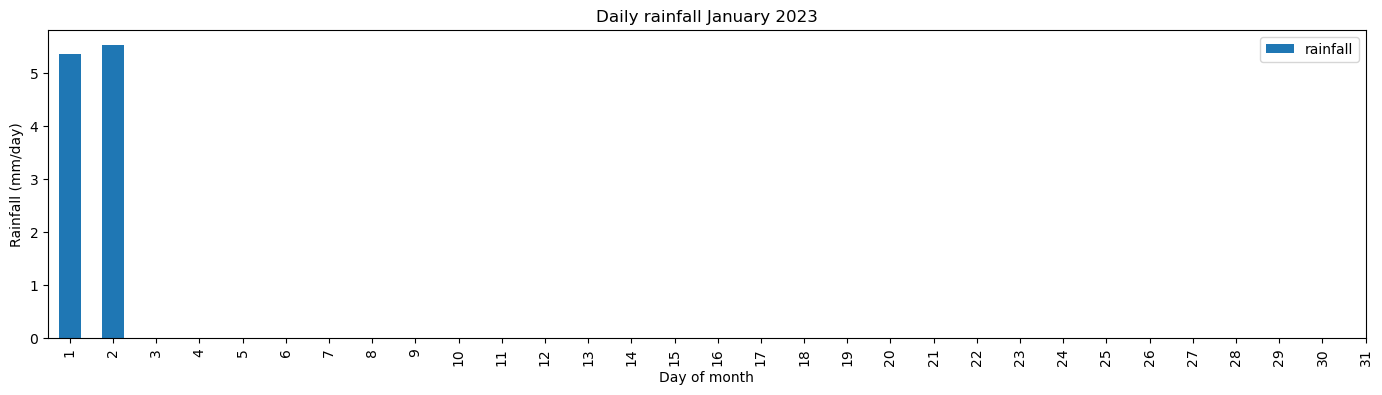

In [62]:
daily_rainfall.plot.bar(figsize=(17,4))
plt.title('Daily rainfall January 2023')
plt.ylabel('Rainfall (mm/day)')
plt.xlabel('Day of month')
plt.xticks(np.arange(0,31,1), np.arange(1,32,1));

# Calculate Monthly total Rainfall

In [ ]:
monthly_total_rainfall = daily_rainfall.resample('ME')['rainfall'].sum()
monthly_total_rainfall